# A3 - (Kalman Filtering and Pair Trading) 

##### Instructions
##### This assignment is to use Kalman filter to implement the pair trading strategy of S&P 500 ETF and the Dow Jones Industrial ETF.

##### Please read the document (Kalman filtering case study.pdf) in Resources/Session 5 folder which discusses the Pair Trading strategy and answer the following questions.

##### (a). Derive the beta update equation (Kalman filter) for the pair trading strategy of the two ETFs ( which is the same format with the last equation on page 72).

##### (b). Code up the pair trading strategy and compare rolling regression vs Kalman filtering.

Rolling Regression:
We estimate a fixed-window linear regression where we regress one asset’s price (e.g. S&P 500 ETF) on the other (Dow Jones ETF) over a rolling window (e.g. 60 days). The slope coefficient is taken as the hedge ratio.

Kalman Filter:
We set up a state-space model where the hedge ratio (and intercept) are allowed to vary over time. The Kalman filter recursively updates these estimates as new data arrives.

In [1]:
# import sys
# import subprocess

# def install_package(package_name, import_name=None):
#     """
#     Check if a package is installed and install it if missing.

#     Parameters:
#     - package_name (str): Name of the package to install via pip.
#     - import_name (str, optional): Name used for import if different from package_name.
#     """
#     import_name = import_name if import_name else package_name
#     try:
#         __import__(import_name)
#     except ImportError:
#         print(f"Installing {package_name}...")
#         subprocess.check_call([sys.executable, "-m", "-pip3", "pip", "install", package_name])

# # Dictionary of required packages with mapping of pip names to import names
# required_packages = {
#     "numpy": "numpy",
#     "pandas": "pandas",
#     "matplotlib": "matplotlib",
#     "statsmodels": "statsmodels",
#     "pykalman": "pykalman",
#     "scikit-learn": "sklearn",
#     "seaborn": "seaborn",
#     "yfinance": "yfinance",
#     "quandl": "quandl",
#     "graphviz": "graphviz",
#     "pandas-ta": "pandas_ta"
# }

# # Install missing packages
# for pip_name, import_name in required_packages.items():
#     install_package(pip_name, import_name)

# # Confirm installation
# print("\nAll required packages are installed and ready to use!")


<Figure size 1200x600 with 0 Axes>

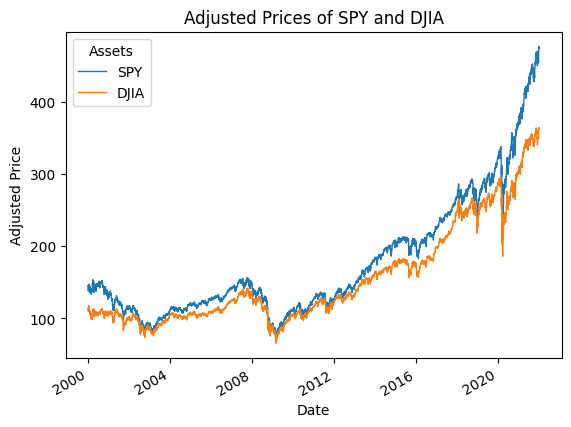

<Figure size 1200x6600 with 0 Axes>

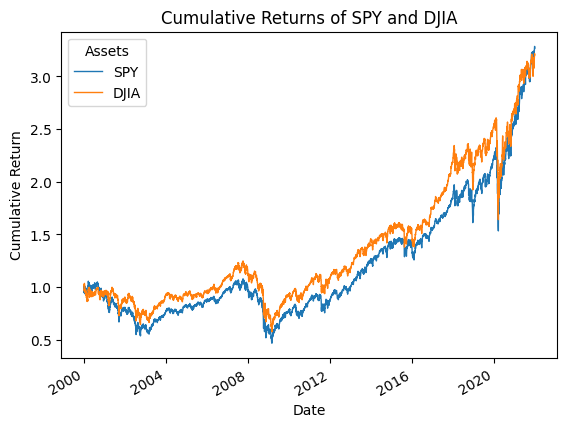

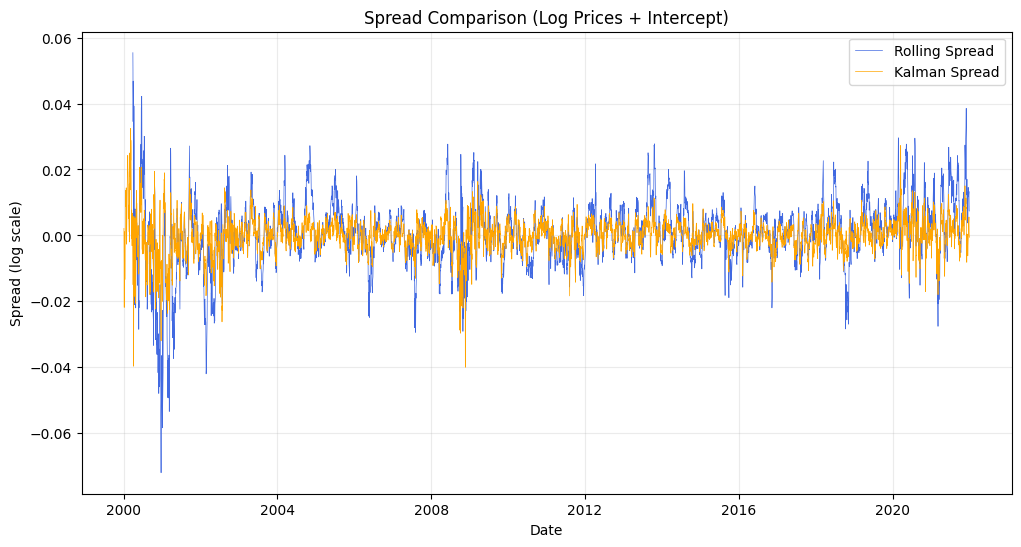

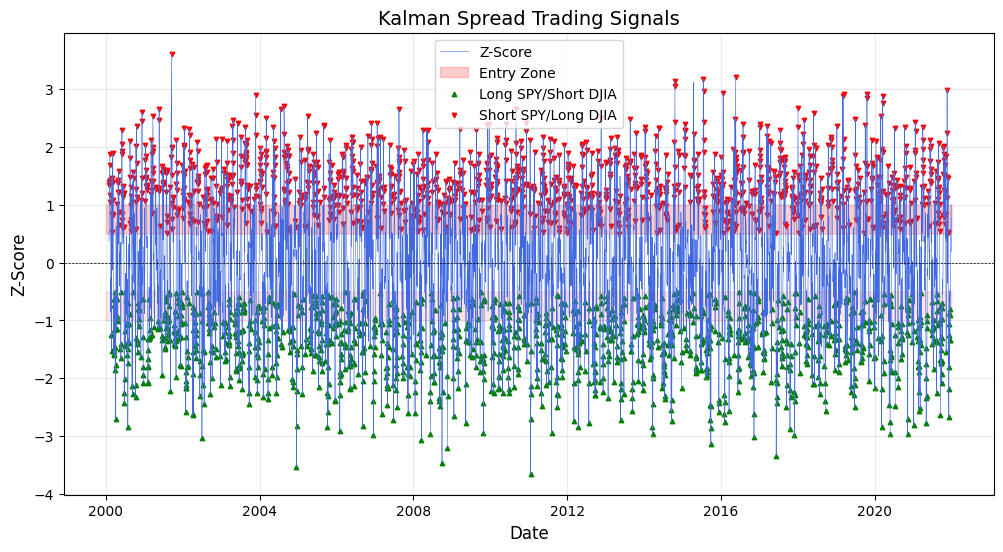

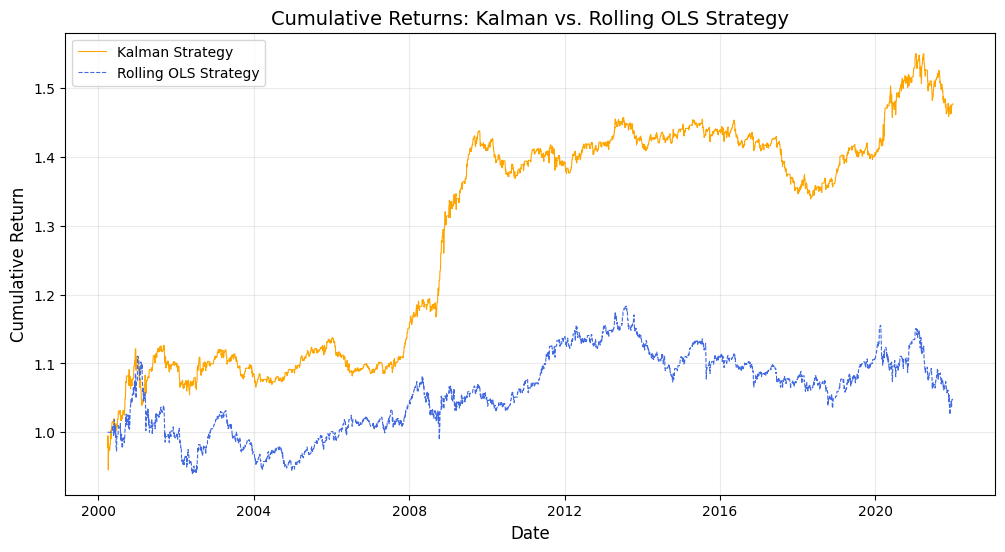

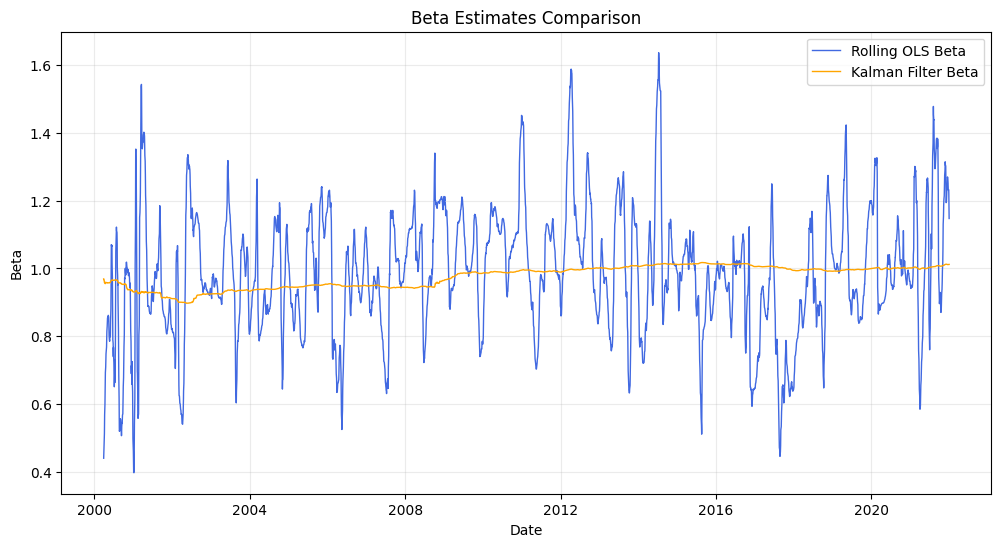

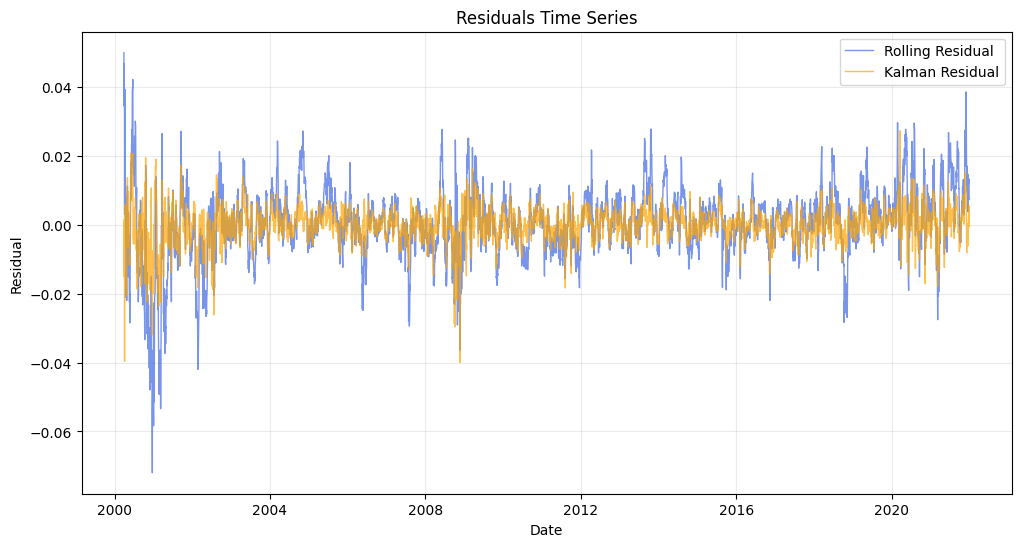

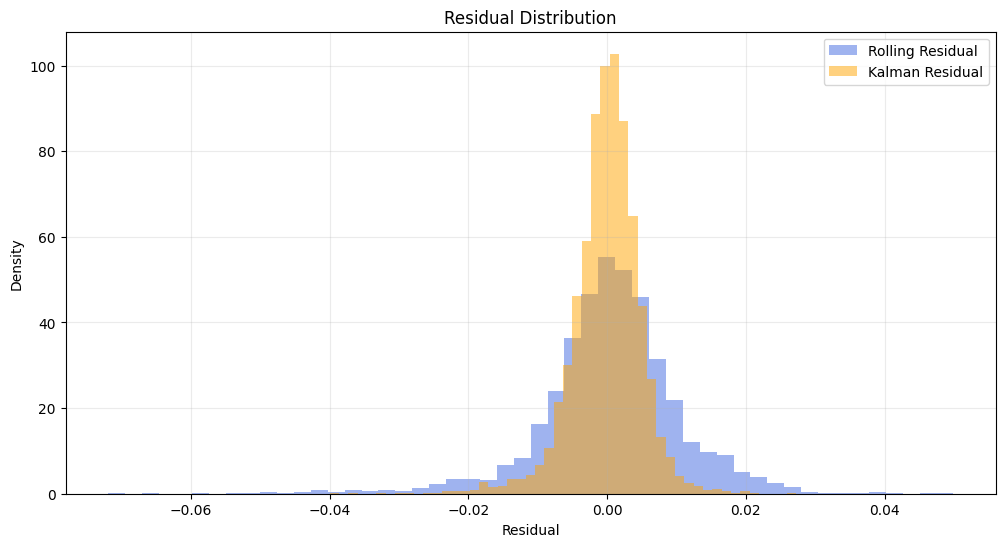

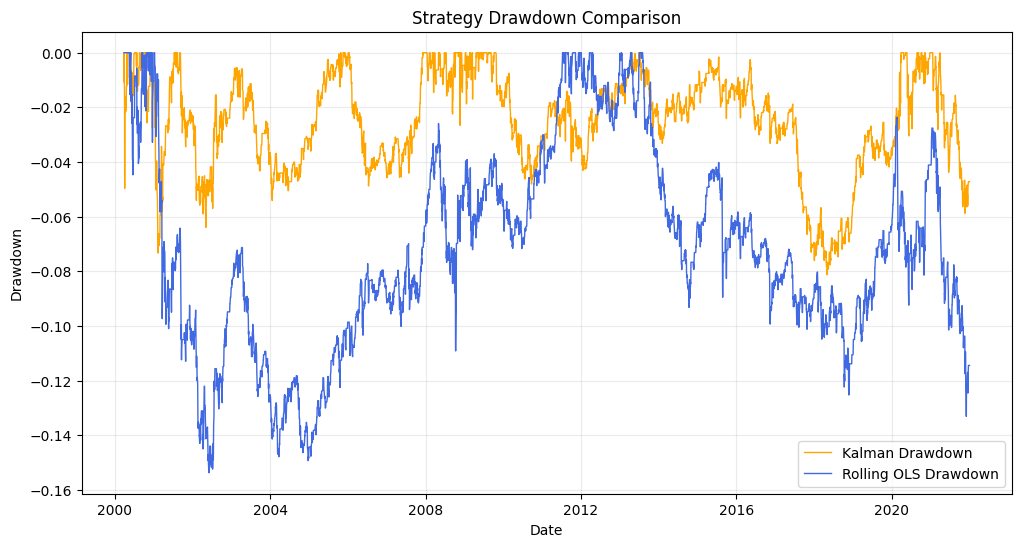

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
from pykalman import KalmanFilter

# -------------------------------
# Returns & Price of SPY and DJIA
# -------------------------------
# Load SPY and DJIA data from CSV files
df_spy = pd.read_csv('spy.csv', parse_dates=['Date'], index_col='Date')
df_djia = pd.read_csv('djia.csv', parse_dates=['Date'], index_col='Date')

# Keep only the PX_LAST column and rename appropriately
df_spy = df_spy[['PX_LAST']].rename(columns={'PX_LAST': 'SPY'})
df_djia = df_djia[['PX_LAST']].rename(columns={'PX_LAST': 'DJIA'})

# Merge datasets based on Date
df = pd.merge(df_spy, df_djia, left_index=True, right_index=True, how='inner')

# Convert index to datetime format (if not already)
df.index = pd.to_datetime(df.index)

# --- Plot Adjusted Prices ---
plt.figure(figsize=(12, 6))
df.plot(lw=1)
plt.legend(title="Assets")
plt.ylabel('Adjusted Price')
plt.title("Adjusted Prices of SPY and DJIA")
plt.show()

# --- Compute Daily Returns ---
df_returns = df.pct_change().dropna()  # Drop first NaN row

# --- Compute Cumulative Returns ---
df_cumulative = (1 + df_returns).cumprod()

# --- Plot Cumulative Returns ---
plt.figure(figsize=(12, 66))
df_cumulative.plot(lw=1)
plt.legend(title="Assets")
plt.ylabel('Cumulative Return')
plt.title("Cumulative Returns of SPY and DJIA")
plt.show()

# -------------------------------
# Kalman & OLS
# -------------------------------
# -------------------------------
# 1. Data Preparation
# -------------------------------
df_spy = pd.read_csv('spy.csv', parse_dates=['Date'])[['Date', 'PX_LAST']]
df_spy.rename(columns={'PX_LAST': 'SPY'}, inplace=True)

df_dji = pd.read_csv('djia.csv', parse_dates=['Date'])[['Date', 'PX_LAST']]
df_dji.rename(columns={'PX_LAST': 'DJIA'}, inplace=True)

df = pd.merge(df_spy, df_dji, on='Date', how='inner').set_index('Date')
df.sort_index(inplace=True)

# Convert to log prices
df['log_spy'] = np.log(df['SPY'])
df['log_dji'] = np.log(df['DJIA'])

# -------------------------------
# 2. Rolling OLS for Comparison
# -------------------------------
df['const'] = 1.0
y = df['log_spy']
X = df[['log_dji', 'const']]
window = 60

rolling_model = RollingOLS(y, X, window=window).fit()
df['beta_rolling']  = rolling_model.params['log_dji']
df['alpha_rolling'] = rolling_model.params['const']
df['spread_rolling'] = df['log_spy'] - (df['alpha_rolling'] + df['beta_rolling'] * df['log_dji'])

# -------------------------------
# 3. Kalman Filter with Intercept
# -------------------------------
delta = 1e-4
obs_cov = 0.1
trans_cov = (delta / (1.0 - delta)) * np.eye(2)

obs_mat = np.vstack([df['log_dji'].values, np.ones(len(df))]).T[:, np.newaxis, :]

kf = KalmanFilter(
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    transition_covariance=trans_cov,
    observation_covariance=obs_cov,
    initial_state_mean=[0, 0],
    initial_state_covariance=np.eye(2)*10
)

state_means, _ = kf.filter(df['log_spy'].values)
df['beta_kalman'] = state_means[:, 0]
df['alpha_kalman'] = state_means[:, 1]
df['spread_kalman'] = df['log_spy'] - (df['alpha_kalman'] + df['beta_kalman'] * df['log_dji'])

# -------------------------------
# 4. Compare Spreads
# -------------------------------
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['spread_rolling'], lw=0.5, label='Rolling Spread', color='royalblue')
plt.plot(df.index, df['spread_kalman'], lw=0.5, label='Kalman Spread', color='orange')
plt.title('Spread Comparison (Log Prices + Intercept)')
plt.xlabel('Date')
plt.ylabel('Spread (log scale)')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# -------------------------------
# 5.A Kalman Spread Trading Logic
# -------------------------------
roll_window_std = 20
df['mean_kalman'] = df['spread_kalman'].rolling(roll_window_std).mean()
df['std_kalman']  = df['spread_kalman'].rolling(roll_window_std).std()
df['zscore_kalman'] = (df['spread_kalman'] - df['mean_kalman']) / df['std_kalman']

# Define thresholds
entry_thresh = 1.0
exit_thresh  = 0.5

# Generate positions: pos_kalman
df['pos_kalman'] = 0
current_pos = 0
for i in range(len(df)):
    z = df['zscore_kalman'].iloc[i]
    if np.isnan(z):
        continue
    if current_pos == 0:
        if z > entry_thresh:
            current_pos = -1  # short SPY, long DJIA
        elif z < -entry_thresh:
            current_pos = 1   # long SPY, short DJIA
    elif current_pos == 1:   # currently long
        if z > -exit_thresh:
            current_pos = 0
    elif current_pos == -1:  # currently short
        if z < exit_thresh:
            current_pos = 0
    df.loc[df.index[i], 'pos_kalman'] = current_pos

# -------------------------------
# 5.B Rolling OLS Spread Trading Logic
# -------------------------------
roll_signal = 20  # Rolling window for OLS-based signals
df['mean_rolling'] = df['spread_rolling'].rolling(roll_signal).mean()
df['std_rolling']  = df['spread_rolling'].rolling(roll_signal).std()
df['zscore_rolling'] = (df['spread_rolling'] - df['mean_rolling']) / df['std_rolling']

df['pos_rolling'] = 0
current_pos_rolling = 0
for i in range(len(df)):
    z = df['zscore_rolling'].iloc[i]
    if np.isnan(z):
        continue
    if current_pos_rolling == 0:
        if z > entry_thresh:
            current_pos_rolling = -1
        elif z < -entry_thresh:
            current_pos_rolling = 1
    elif current_pos_rolling == 1:
        if z > -exit_thresh:
            current_pos_rolling = 0
    elif current_pos_rolling == -1:
        if z < exit_thresh:
            current_pos_rolling = 0
    df.loc[df.index[i], 'pos_rolling'] = current_pos_rolling

# -------------------------------
# 6. Enhanced Trading Signals Plot (Kalman)
# -------------------------------
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['zscore_kalman'], label='Z-Score', lw=0.4, color='royalblue')
plt.fill_between(df.index, entry_thresh, exit_thresh, color='red', alpha=0.2, label='Entry Zone')
plt.fill_between(df.index, -entry_thresh, -exit_thresh, color='red', alpha=0.1)
plt.axhline(0, color='black', lw=0.5, ls='--')

long_entries = df[df['pos_kalman'] == 1]
short_entries = df[df['pos_kalman'] == -1]
plt.scatter(long_entries.index, long_entries['zscore_kalman'], marker='^', color='green', s=10, label='Long SPY/Short DJIA')
plt.scatter(short_entries.index, short_entries['zscore_kalman'], marker='v', color='red', s=10, label='Short SPY/Long DJIA')

plt.title('Kalman Spread Trading Signals', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Z-Score', fontsize=12)
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# -------------------------------
# 7. Strategy Returns (Naive)
# -------------------------------
df['dlog_spy'] = df['log_spy'].diff()
df['dlog_dji'] = df['log_dji'].diff()

df['strategy_ret_kalman'] = df['pos_kalman'].shift(1) * (df['dlog_spy'] - df['beta_kalman'].shift(1) * df['dlog_dji'])
df['strategy_ret_rolling'] = df['pos_rolling'].shift(1) * (df['dlog_spy'] - df['beta_rolling'].shift(1) * df['dlog_dji'])

df.dropna(subset=['strategy_ret_kalman', 'strategy_ret_rolling'], inplace=True)

df['cum_ret_kalman'] = np.exp(df['strategy_ret_kalman'].cumsum())
df['cum_ret_rolling'] = np.exp(df['strategy_ret_rolling'].cumsum())

# -------------------------------
# 8. Plot Cumulative Returns for Both Strategies
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(df.index, df['cum_ret_kalman'], label='Kalman Strategy', lw=0.8, color='orange')
plt.plot(df.index, df['cum_ret_rolling'], label='Rolling OLS Strategy', lw=0.8, ls='--', color='royalblue')
plt.title('Cumulative Returns: Kalman vs. Rolling OLS Strategy', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# -------------------------------
# 9. Additional Diagnostic Plots
# -------------------------------

# (A) Beta Comparison Plot
plt.figure(figsize=(12,6))
plt.plot(df.index, df['beta_rolling'], label='Rolling OLS Beta', lw=1, color='royalblue')
plt.plot(df.index, df['beta_kalman'], label='Kalman Filter Beta', lw=1, color='orange')
plt.title('Beta Estimates Comparison')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# (B) Residual Analysis
# Compute residuals
df['resid_rolling'] = df['log_spy'] - (df['alpha_rolling'] + df['beta_rolling'] * df['log_dji'])
df['resid_kalman']  = df['log_spy'] - (df['alpha_kalman'] + df['beta_kalman'] * df['log_dji'])

# Residuals time series
plt.figure(figsize=(12,6))
plt.plot(df.index, df['resid_rolling'], label='Rolling Residual', lw=1, alpha=0.7, color='royalblue')
plt.plot(df.index, df['resid_kalman'], label='Kalman Residual', lw=1, alpha=0.7, color='orange')
plt.title('Residuals Time Series')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# Residuals histogram
plt.figure(figsize=(12,6))
plt.hist(df['resid_rolling'].dropna(), bins=50, alpha=0.5, label='Rolling Residual', density=True, color='royalblue')
plt.hist(df['resid_kalman'].dropna(), bins=50, alpha=0.5, label='Kalman Residual', density=True, color='orange')
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.25)
plt.show()

# (C) Drawdown Analysis
def compute_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown

df['drawdown_kalman'] = compute_drawdown(df['cum_ret_kalman'])
df['drawdown_rolling'] = compute_drawdown(df['cum_ret_rolling'])

plt.figure(figsize=(12,6))
plt.plot(df.index, df['drawdown_kalman'], label='Kalman Drawdown', lw=1, color='orange')
plt.plot(df.index, df['drawdown_rolling'], label='Rolling OLS Drawdown', lw=1, color='royalblue')
plt.title('Strategy Drawdown Comparison')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(alpha=0.25)
plt.show()


In [3]:
# -------------------------------
# Residuals & MSE for Each Model
# -------------------------------

from statsmodels.tsa.stattools import adfuller


# Rolling OLS predictions and residuals
df['pred_rolling'] = df['alpha_rolling'] + df['beta_rolling'] * df['log_dji']
df['resid_rolling'] = df['log_spy'] - df['pred_rolling']
mse_rolling = np.mean(df['resid_rolling']**2)

# Kalman Filter predictions and residuals
df['pred_kalman'] = df['alpha_kalman'] + df['beta_kalman'] * df['log_dji']
df['resid_kalman'] = df['log_spy'] - df['pred_kalman']
mse_kalman = np.mean(df['resid_kalman']**2)

print("Rolling OLS Residual MSE: {:.6f}".format(mse_rolling))
print("Kalman Filter Residual MSE: {:.6f}".format(mse_kalman))

# -------------------------------
# 2. Test for Stationarity (ADF Test) on the Spreads
# -------------------------------
adf_rolling = adfuller(df['spread_rolling'].dropna())
adf_kalman = adfuller(df['spread_kalman'].dropna())

print("\nADF Test for Rolling Spread:")
print(" Test Statistic: {:.4f}, p-value: {:.4f}".format(adf_rolling[0], adf_rolling[1]))
print("\nADF Test for Kalman Spread:")
print(" Test Statistic: {:.4f}, p-value: {:.4f}".format(adf_kalman[0], adf_kalman[1]))

# -------------------------------
# 3. Compute Trading Performance Metrics
# -------------------------------
# First, calculate cumulative returns (assuming strategy_ret columns are log returns)
df['cum_ret_kalman'] = np.exp(df['strategy_ret_kalman'].cumsum())
df['cum_ret_rolling'] = np.exp(df['strategy_ret_rolling'].cumsum())

# Define helper functions for Sharpe ratio and max drawdown
def compute_sharpe(returns, freq=252):
    # Assuming risk-free rate is 0
    return returns.mean() / returns.std() * np.sqrt(freq)

def max_drawdown(cum_returns):
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    return drawdown.min()  # This will be a negative number

# Compute Sharpe ratios
sharpe_kalman = compute_sharpe(df['strategy_ret_kalman'].dropna())
sharpe_rolling = compute_sharpe(df['strategy_ret_rolling'].dropna())

# Compute maximum drawdowns
max_dd_kalman = max_drawdown(df['cum_ret_kalman'])
max_dd_rolling = max_drawdown(df['cum_ret_rolling'])

# Get final cumulative returns
final_cum_ret_kalman = df['cum_ret_kalman'].iloc[-1]
final_cum_ret_rolling = df['cum_ret_rolling'].iloc[-1]

print("\nKalman Strategy Performance:")
print(" Final Cumulative Return: {:.2f}".format(final_cum_ret_kalman))
print(" Sharpe Ratio: {:.2f}".format(sharpe_kalman))
print(" Maximum Drawdown: {:.2%}".format(abs(max_dd_kalman)))

print("\nRolling OLS Strategy Performance:")
print(" Final Cumulative Return: {:.2f}".format(final_cum_ret_rolling))
print(" Sharpe Ratio: {:.2f}".format(sharpe_rolling))
print(" Maximum Drawdown: {:.2%}".format(abs(max_dd_rolling)))


Rolling OLS Residual MSE: 0.000103
Kalman Filter Residual MSE: 0.000025

ADF Test for Rolling Spread:
 Test Statistic: -7.4123, p-value: 0.0000

ADF Test for Kalman Spread:
 Test Statistic: -14.8291, p-value: 0.0000

Kalman Strategy Performance:
 Final Cumulative Return: 1.48
 Sharpe Ratio: 0.45
 Maximum Drawdown: 8.12%

Rolling OLS Strategy Performance:
 Final Cumulative Return: 1.05
 Sharpe Ratio: 0.05
 Maximum Drawdown: 15.38%


##### Spread Comparison (Log Prices + Intercept) 
Log prices ensure that percentage changes in SPY and DJIA are comparable over time, making the spread calculation more robust to price scale differences. The mean of the log price spread represents the average log deviation between the two assets, indicating how far their relationship drifts over time, with a properly mean-reverting spread expected to center around zero. In comparison to raw prices, using log prices smooths out large price swings and allows for more stable parameter estimation in the Kalman filter and Rolling OLS models, leading to a more reliable spread for trading signals.

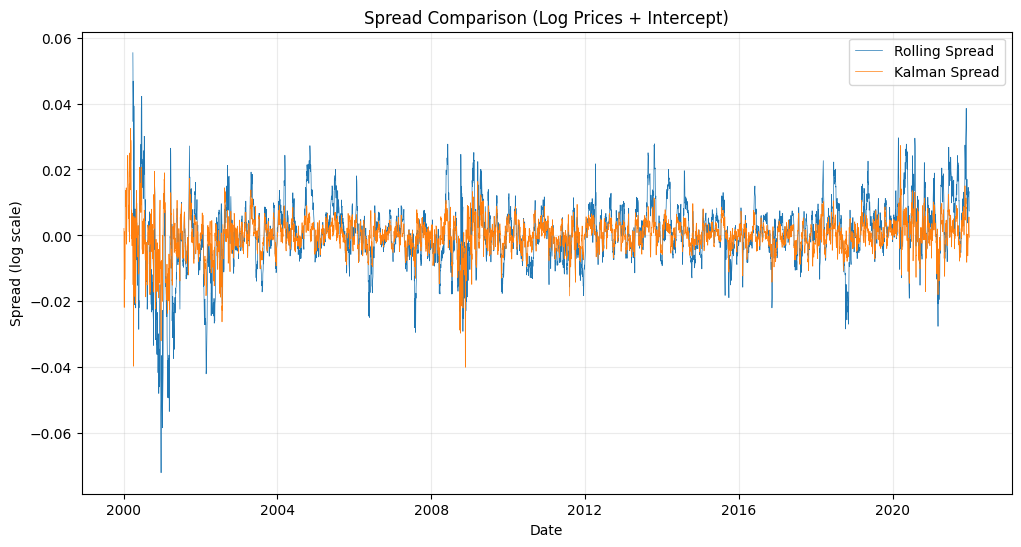

##### Kalman Spread Trading Signals
The blue line represents the z-score of the Kalman-filtered spread, showing deviations from the mean, which determine trade entry and exit signals. The red and green markers indicate trading signals, where red triangles signal short positions (SPY short, DJIA long) and green triangles signal long positions (SPY long, DJIA short). Frequent trading signals indicate excessive noise or overly sensitive thresholds, suggesting that optimizing the rolling window or entry/exit thresholds might improve strategy performance by filtering out false signals.

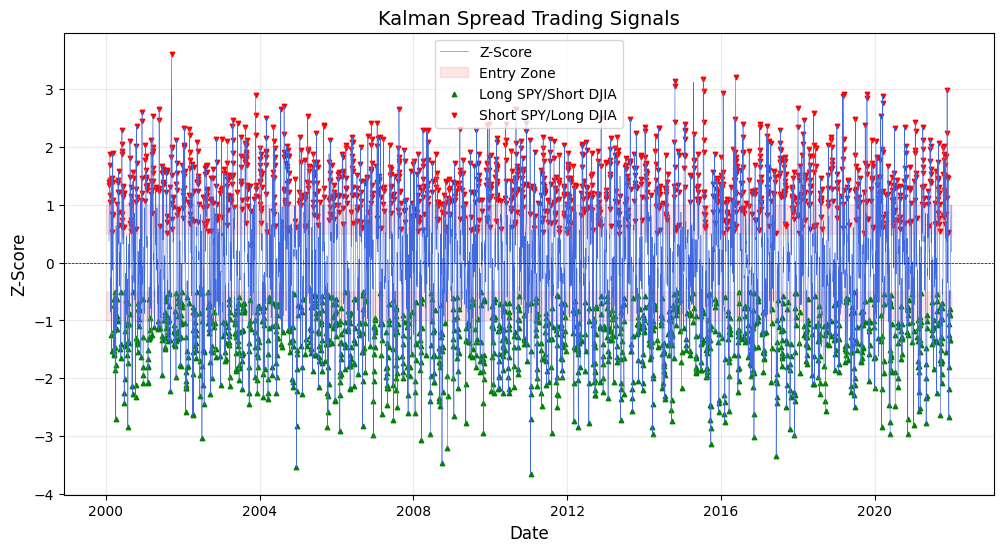

##### Cumulative Returns: Kalman vs. Rolling OLS Strategy
The Kalman filter strategy significantly outperforms the Rolling OLS strategy, showing a strong and consistent upward trend, especially post-2008, where it captures structural market shifts better. The Rolling OLS strategy exhibits weaker performance and greater stagnation, suggesting that a static window approach struggles to adapt dynamically to market conditions. Kalman’s adaptive filtering mechanism provides better trend-following capability, allowing it to adjust to changes in the hedge ratio more effectively, leading to superior returns over the long run.

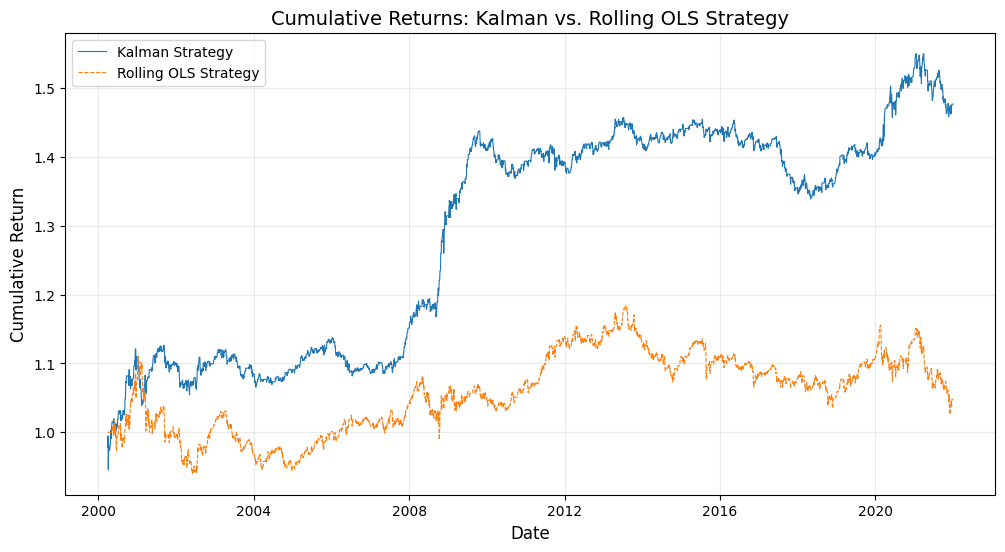

##### Residual Time Series & Distribution
The residual time series graph shows that the Kalman filter residuals (orange) are generally smoother than the Rolling OLS residuals (blue). This tells us that the Kalman filter adapts dynamically to changing market conditions, whereas the Rolling OLS regression has more abrupt changes due to the fixed window length. The histogram of residuals shows that the Kalman filter residuals are more tightly centered around zero, while the Rolling OLS residuals have a wider spread. This suggests that the Kalman filter is better at reducing noise and maintaining a more stable hedge ratio over time.

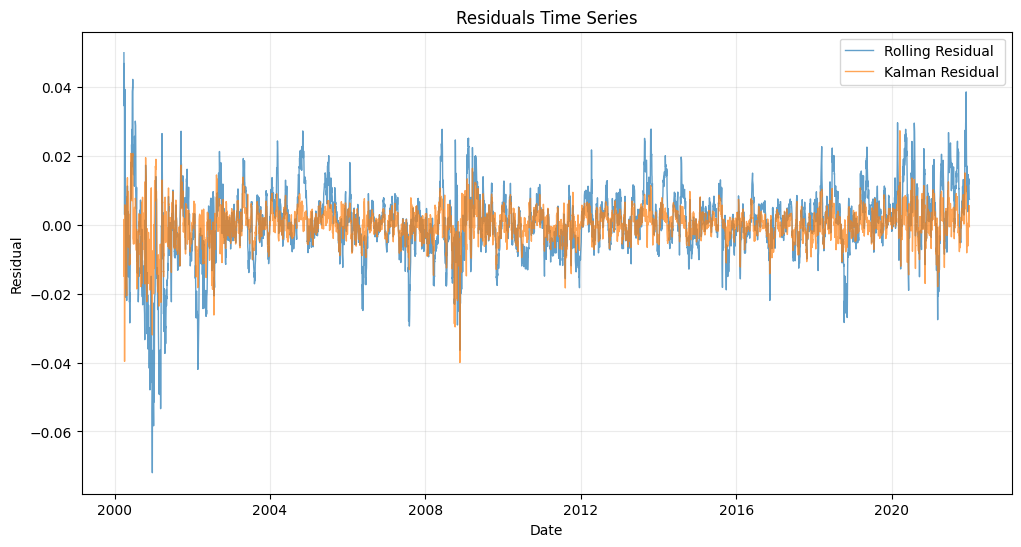
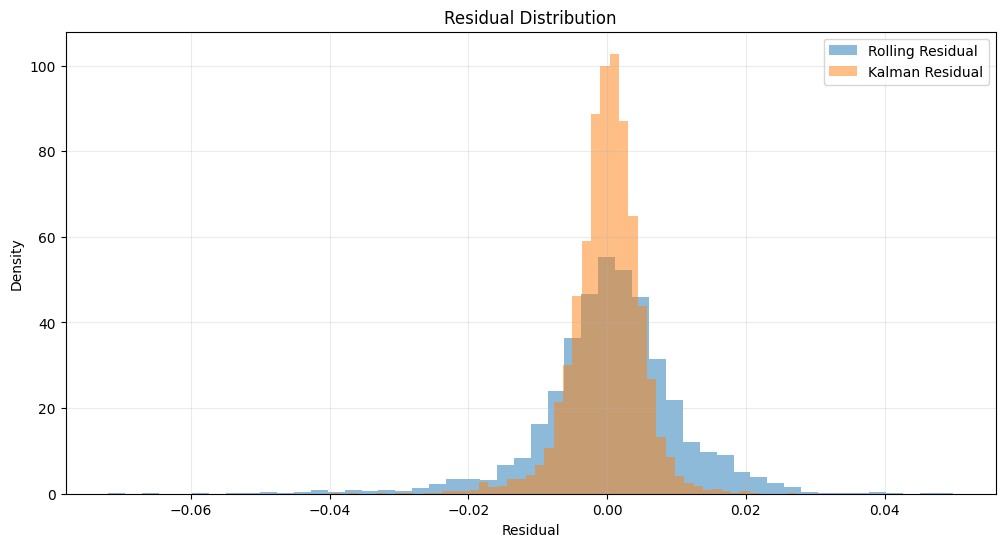

##### Strategy Drawdown Curve

The Kalman filter (orange line) exhibits shallower drawdowns compared to the Rolling OLS strategy (blue line). This suggests that the Kalman-based strategy experiences smaller peak-to-trough declines, indicating a more stable performance over time. The Rolling OLS strategy has more severe and prolonged drawdowns, particularly in periods of market stress (e.g., 2008 financial crisis and recent volatility around 2020). This implies that the fixed-window regression may struggle to adapt to changing market conditions, leading to significant losses in unfavorable environments. Since drawdowns measure the worst-case downside from a previous peak, a lower drawdown indicates a more resilient strategy. The Kalman filter’s ability to dynamically adjust hedge ratios helps mitigate risks, making it more robust compared to the static nature of the rolling regression.

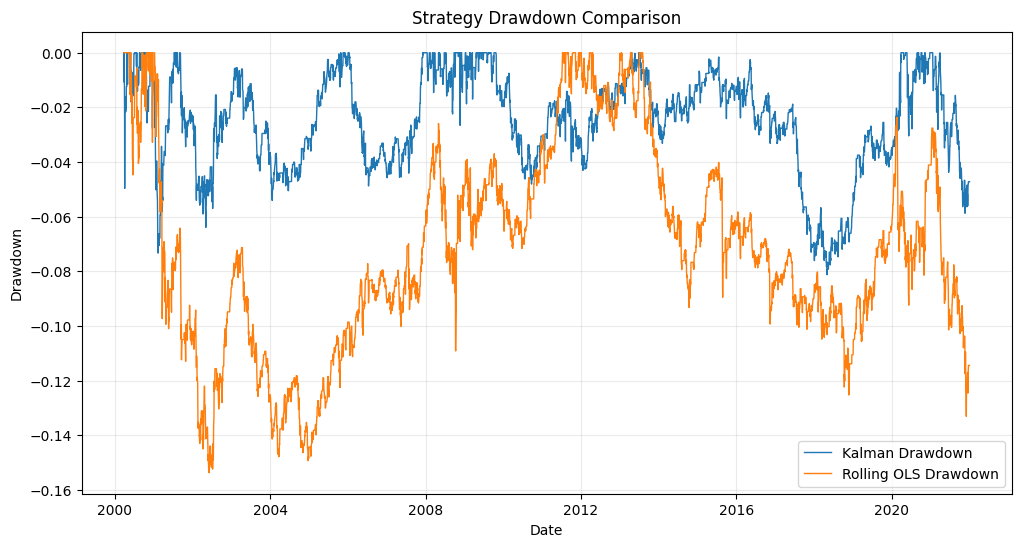

##### Residuals & MSE for Each Model
The **Kalman Filter** is the superior approach, with **better stability (lower MSE: 0.000025 vs. 0.000103)**, **stronger mean reversion (ADF Test Statistic: -14.8291 vs. -7.4123)**, and **higher risk-adjusted returns (Sharpe Ratio: 0.45 vs. 0.05)**.  

The **Rolling OLS approach** is weaker, with **higher residual errors (MSE: 0.000103 vs. 0.000025)**, **weaker mean reversion (-7.4123 vs. -14.8291 ADF Test Statistic)**, and **lower overall returns (Final Cumulative Return: 1.05 vs. 1.48)**.  

The **maximum drawdown is significantly better for Kalman** (**8.12% vs. 15.38%**), meaning **lower risk exposure during market downturns**.
